In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker

# 1D

In [2]:
np.random.seed(10)

In [3]:
# model
nt0 = 301 # Number of samples
dt0 = 0.004 # Sampling interval
t0 = np.arange(nt0)*dt0 # time series

In [4]:
vp = 1200 + np.arange(nt0) + \
     filtfilt(np.ones(5)/5., 1, np.random.normal(0, 80, nt0))

rho = 1000 + vp + \
      filtfilt(np.ones(5)/5., 1, np.random.normal(0, 30, nt0))

vp[131:] += 500

rho[131:] += 100

In [5]:
imp = vp*rho

In [6]:
imp_current = imp[:-1] # current layer
imp_next = imp[1:] # next layer

rc = (imp_next - imp_current) / (imp_next + imp_current)

In [7]:
m = np.log(imp)

In [8]:
# wavelet
ntwav = 41
wav, twav, wavc = ricker(t0[:ntwav//2+1], 20)

In [9]:
Cop = pylops.signalprocessing.Convolve1D(nt0-1, h=wav, offset=wavc, dtype='float32')

syn_rc = Cop*rc # Synthetic seismic from reflection coefficient

In [10]:
# dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nt0, explicit=True)

syn_imp = PPop_dense*m # Synthetic seismic from P-impedance

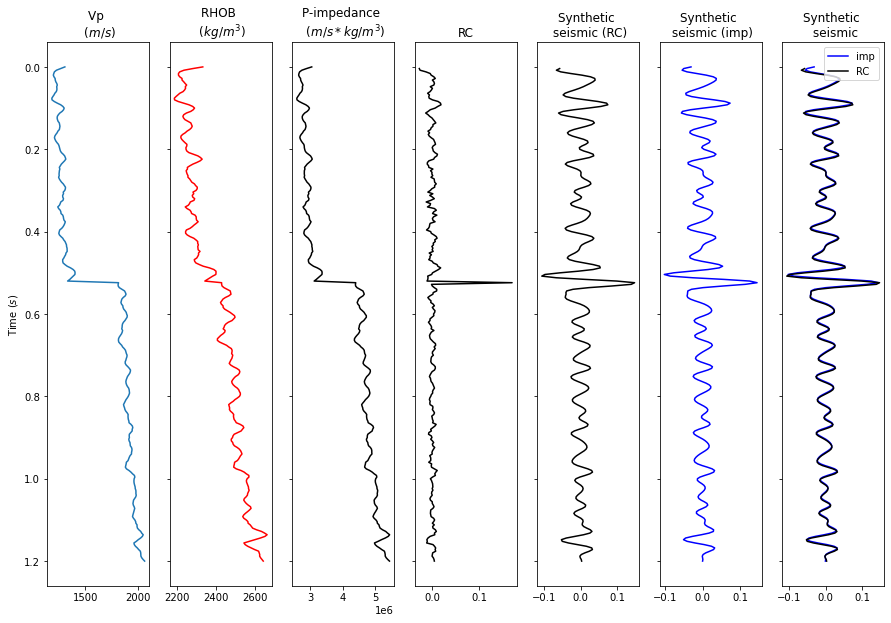

In [11]:
fig, axs = plt.subplots(1, 7, figsize=(15, 10), sharey=True)

axs[0].plot(vp, t0)
axs[0].set_title('Vp \n ($m/s$)')

axs[1].plot(rho, t0, 'r')
axs[1].set_title('RHOB \n ($kg/m^3$)')

axs[2].plot(imp, t0, 'k')
axs[2].set_title('P-impedance \n ($m/s*kg/m^3$)')

axs[3].plot(rc, t0[1:], 'k')
axs[3].set_title('RC')

axs[4].plot(syn_rc, t0[1:], 'k')
axs[4].set_title('Synthetic \n seismic (RC)')

axs[5].plot(syn_imp, t0, 'b')
axs[5].set_title('Synthetic \n seismic (imp)')

axs[6].plot(syn_imp, t0, 'b', label='imp')
axs[6].plot(syn_rc, t0[1:], 'k', label='RC')
axs[6].set_title('Synthetic \n seismic')
axs[6].legend(loc=1)


axs[0].invert_yaxis()
axs[0].set_ylabel('Time ($s$)')

plt.show()

# 2D

In [12]:
# model
inputfile = 'data/poststack_model.npz'

In [13]:
model = np.load(inputfile)

In [14]:
m = model['model']
m.shape

(550, 800)

In [15]:
x = model['x']
nx = len(x)
x.shape

(800,)

In [16]:
z = model['z'] / 1000
nz = len(z)
z.shape

(550,)

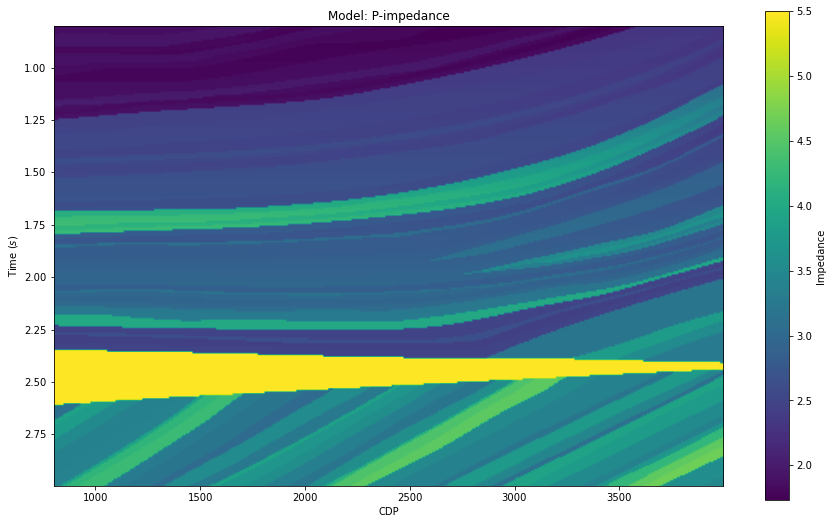

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(15, 9))

im = axs.imshow(m,
                extent=(x[0], x[-1], z[-1], z[0]),
                vmin=m.min(), vmax=m.max(),
                aspect=1000)

fig.colorbar(im, label='Impedance')

plt.xlabel('CDP')
plt.ylabel('Time ($s$)')
plt.title('Model: P-impedance')

plt.show()

## Synthetic seismic from P-impedace

In [18]:
# dense operator
PPop_dense = \
    pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz,
                                                  spatdims=nx, explicit=True)

In [19]:
m_ln = np.log(m)

# synthetic data
d_imp = (PPop_dense * m_ln.flatten()).reshape(nz, nx)

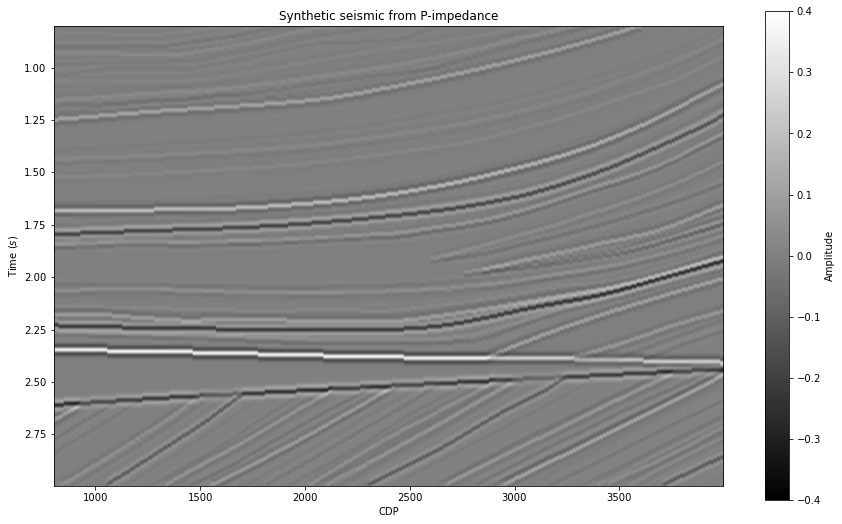

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(15, 9))

im = axs.imshow(d_imp,
                cmap='gray',
                extent=(x[0], x[-1], z[-1], z[0]),
                vmin=-0.4, vmax=0.4,
                aspect=1000)

fig.colorbar(im, label='Amplitude')

plt.xlabel('CDP')
plt.ylabel('Time ($s$)')
plt.title('Synthetic seismic from P-impedance')

plt.show()

## Synthetic from reflection coefficients

In [21]:
m_current = m[:-1, :]
m_next = m[1:, :]

m_rc = (m_next - m_current) / (m_next + m_current)

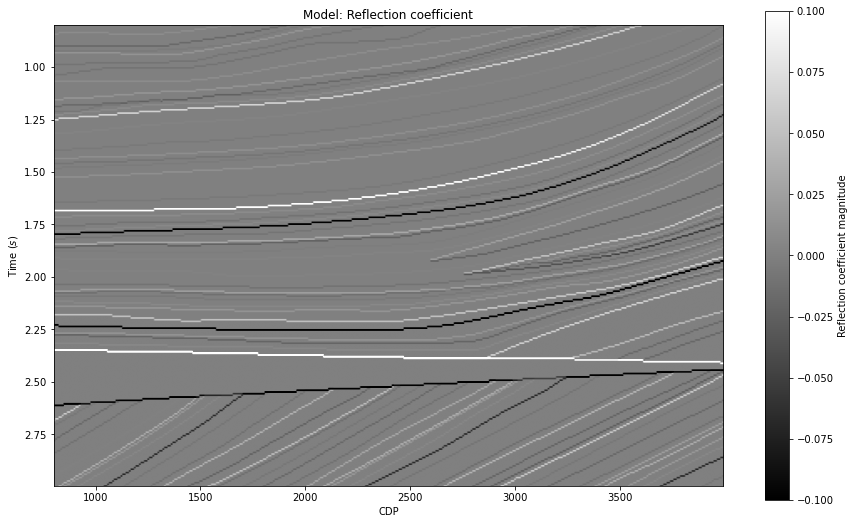

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(15, 9))

im = axs.imshow(m_rc,
                cmap='gray',
                extent=(x[0], x[-2], z[-1], z[0]),
                vmin=-0.1, vmax=0.1,
                aspect=1000)

fig.colorbar(im, label='Reflection coefficient magnitude')

plt.xlabel('CDP')
plt.ylabel('Time ($s$)')
plt.title('Model: Reflection coefficient')

plt.show()

In [23]:
Cop = pylops.signalprocessing.Convolve1D((nz-1)*nx,
                                         h=wav,
                                         offset=wavc,
                                         dims=(nz-1, nx),
                                         dir=0,
                                         dtype='float32')

# Synthetic seismic from reflection coefficient
syn_rc = (Cop * m_rc.flatten()).reshape(nz-1, nx)

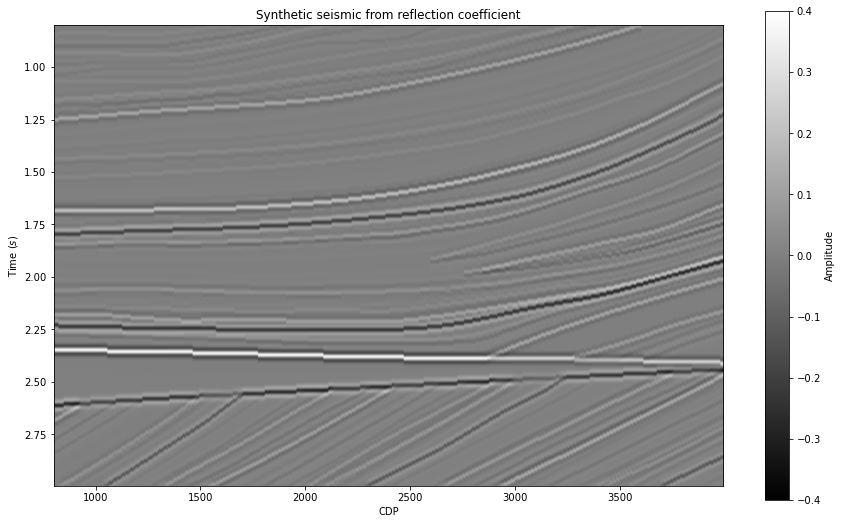

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(15, 9))

im = axs.imshow(syn_rc,
                cmap='gray',
                extent=(x[0], x[-2], z[-1], z[0]),
                vmin=-0.4, vmax=0.4,
                aspect=1000)

fig.colorbar(im, label='Amplitude')

plt.xlabel('CDP')
plt.ylabel('Time ($s$)')
plt.title('Synthetic seismic from reflection coefficient')

plt.show()